# Tutorial of Reinforcement Learning (DQN/MountainCar)

Please get in touch if interested in our future collaboration of science and/or business!\
Daiphys Technologies LLC - https://www.daiphys.com/

## 0. References

- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- https://sebarnold.net/tutorials/intermediate/reinforcement_q_learning.html
- https://www.gymlibrary.dev/
- https://www.gymlibrary.dev/environments/classic_control/mountain_car/
- https://github.com/openai/gym/wiki/MountainCar-v0
- https://unproductive.dev/rl-implementation-dqn/
- https://take-tech-engineer.com/dqn-atari-breakout-pytorch/
- https://github.com/bentrevett/pytorch-rl
- https://qiita.com/payanotty/items/07fb38a44cc3bd13e4dd
- https://www.kaggle.com/code/fabriciotorquato/mountaincar-dqn
- https://blog.tanka.la/2018/10/19/solving-curious-case-of-mountaincar-reward-problem-using-openai-gym-keras-tensorflow-in-python/

## 1. Preparation

### 1.1. Install

In [1]:
## Python
!python --version

Python 3.10.12


In [2]:
## PyTorch
!python -c 'import torch; print(torch.__version__)'

2.2.1+cu121


In [3]:
## CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [737 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,569 kB]
Get:13 http://archive.ubuntu.c

In [6]:
!pip install --upgrade gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00


In [7]:
## Gymnasium 0.20.0+
!python -c 'import gymnasium; print(gymnasium.__version__)'

0.29.1


In [8]:
## X11 Virtual Framebuffer
#!apt-get install -y xvfb
#!apt-get install -y python-opengl
#!apt-get install -y ffmpeg
#!pip install pyvirtualdisplay

### 1.2. Import

In [9]:
#!pip list
#!pip freeze > requirements.txt

In [10]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import re
import csv
import math
import random
import time
import datetime

In [11]:
#from google.colab.patches import cv2_imshow

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
import gymnasium as gym

In [14]:
from collections import namedtuple
from collections import deque
from itertools import count

In [15]:
import glob
import io
import base64
import IPython

In [16]:
import pygame
import moviepy

In [17]:
from typing import Optional

In [18]:
## X11 Virtual Framebuffer
#import pyvirtualdisplay
#display = pyvirtualdisplay.Display(visible=0, size=(1024, 768))
#display.start()

In [19]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = [12, 8]

In [20]:
plt.ion()

### 1.3. Setup

In [21]:
project = 'mountaincar'

In [22]:
output_dir = project + '/output'
checkpoint_dir = project + '/checkpoint'

In [23]:
!mkdir -p $output_dir
!mkdir -p $checkpoint_dir

In [24]:
if torch.cuda.is_available() :
    device = 'cuda'
    #device = 'cuda:0'
else :
    device = 'cpu'

## 2. Sample (MountainCar)

### 2.1. Environment

#### 2.1.1. Environment Setup

In [25]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [26]:
env = gym.wrappers.RecordVideo(env, output_dir)
#env = gym.wrappers.RecordVideo(env, output_dir, episode_trigger=(lambda ep: ep == 0 or ep == 9 or ep % 100 == 99))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/mountaincar/output folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [27]:
## Action Space
env.action_space

Discrete(3)

In [28]:
## Observation Space
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [29]:
## Reward Range
env.reward_range

(-inf, inf)

In [30]:
state, info = env.reset(seed=random.randint(0, (2**24)))
state, info

(array([-0.5176185,  0.       ], dtype=float32), {})

In [31]:
img = env.render()

In [32]:
state_text_01 = f'position = {state[0]:.2f}\n'
state_text_01 += f'velocity = {state[1]:.3f}'
state_text_02 = f'steps = 0'

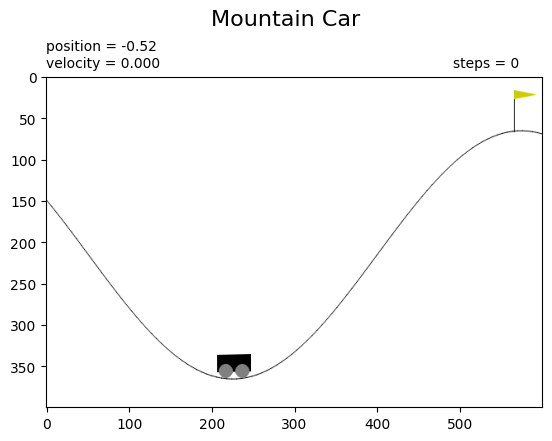

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Mountain Car', fontsize=16)
plt.imshow(img)
plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
plt.text(0.82, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
plt.show()

### 2.2. Algorithm

#### 2.2.1. Experience Replay Memory

In [34]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [35]:
class ReplayMemory(object) :
    def __init__(self, capacity) :
        self.memory = deque([], maxlen=capacity)
    def push(self, *args) :
        self.memory.append(Transition(*args))
    def sample(self, batch_size) :
        return random.sample(self.memory, batch_size)
    def __len__(self) :
        return len(self.memory)

#### 2.2.2. Network

##### 2.2.2.1. DQN - Multilayer Perceptron (MLP)

In [36]:
class DQN_MLP(nn.Module) :
    def __init__(self, n_observations, n_actions) :
        super(DQN_MLP, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x) :
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

##### 2.2.2.2. DQN - Multilayer Perceptron (MLP) with Dropout Layers

In [37]:
class DQN_MLP_DROPOUT(nn.Module) :
    def __init__(self, n_observations, n_actions) :
        super(DQN_MLP_DROPOUT, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.dropout1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x) :
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        return self.layer3(x)

#### 2.2.3. Action Selection (Epsilon-Greedy Algorithm)

In [38]:
def select_action(state) :
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold :
        with torch.no_grad() :
            return policy_net(state).max(1)[1].view(1, 1), eps_threshold
    else :
        ## Random Action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold

#### 2.2.4. Training Loop

In [39]:
def optimize_model() :
    global state_action_values
    global loss
    if len(memory) < BATCH_SIZE :
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad() :
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()

#### 2.2.5. Plot Function

In [40]:
def plot_rewards(realtime=False) :
    fig = plt.figure()
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    steps = torch.tensor(episode_steps, dtype=torch.int)
    if realtime :
        plt.clf()
        plt.suptitle('Training...')
    else :
        plt.suptitle('Training Result')
    ax1 = fig.add_subplot(2, 1, 1)
    #ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(linestyle='--')
    ax1.tick_params('x', length=0)
    ax1.plot(rewards.numpy())
    if len(rewards) >= 100 :
        bin = 100
    else :
        bin = len(rewards)
    means = rewards.unfold(0, bin, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(bin - 1) + means[0], means))
    ax1.plot(means.numpy())
    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.grid(linestyle='--')
    ax2.plot(steps.numpy())
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0.10)
    plt.pause(0.001)
    if realtime :
        IPython.display.display(plt.gcf())
        IPython.display.clear_output(wait=True)
    else :
        IPython.display.display(plt.gcf())

#### 2.2.6. Utilities

In [41]:
def atoi(text) :
    return int(text) if text.isdigit() else text

In [42]:
def natural_keys(text) :
    return [atoi(c) for c in re.split(r'(\d+)', text)]

### 2.3. Training

#### 2.3.1. Hyperparameters

In [43]:
## Q-Learning: Batch Size
BATCH_SIZE = 128

In [44]:
## Q-Learning: Discount Factor
GAMMA = 0.99

In [45]:
## Epsilon-Greedy Thresholds
EPS_START = 0.90
EPS_END = 0.05
EPS_DECAY = 500

In [46]:
## Target Network: Update Rate
TAU = 0.005

In [47]:
## Optimizer: Learning Rate
LR = 1e-04

#### 2.3.2. Model Initialization

In [48]:
n_actions = env.action_space.n

In [49]:
#n_observations = len(state)
n_observations = state.size

In [50]:
#policy_net = DQN_MLP(n_observations, n_actions).to(device)
#target_net = DQN_MLP(n_observations, n_actions).to(device)
policy_net = DQN_MLP_DROPOUT(n_observations, n_actions).to(device)
target_net = DQN_MLP_DROPOUT(n_observations, n_actions).to(device)

In [51]:
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [52]:
## In case of recovery
#policy_net.load_state_dict(torch.load(checkpoint_dir + '/policy_net_final.pth'))
#target_net.load_state_dict(torch.load(checkpoint_dir + '/target_net_final.pth'))

In [53]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [54]:
memory = ReplayMemory(10000)
#memory = ReplayMemory(100000)

In [55]:
steps_done = 0
state_action_values = np.array(0.0)
loss = 0.0

In [56]:
episode_rewards = []
episode_steps = []

#### 2.3.3. Training

In [57]:
num_episodes = 2000

In [58]:
num_episodes_save = 100

In [59]:
def energy(state) :
    x = state[0]
    v = state[1]
    m = 1.0
    g = 0.0025
    h = np.sin((x - (0.5 * np.pi)) + 0.5) + 1.0
    u = m * g * h
    k = 0.5 * v * v
    xmax = 0.6
    vmax = 0.07
    n = 1 / ((m * g * (np.sin((xmax - (0.5 * np.pi)) + 0.5) + 1.0)) + (0.5 * vmax * vmax))
    e = n * (u + k)
    return e

<Figure size 640x480 with 0 Axes>

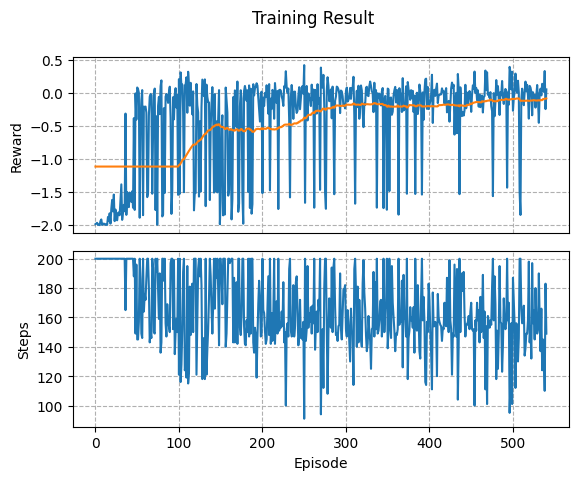

<Figure size 640x480 with 0 Axes>

episode: 541, steps: 156, reward: -0.059, loss: 9.201e-04, mean_q: 2.893e-01


In [ ]:
for i_episode in range(num_episodes) :
    state, info = env.reset(seed=random.randint(0, (2**24)))
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_total = 0
    for t in count() :
        action, eps_threshold = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        ################################################################################
        ## Reward Modification
        ################################################################################
        ## 1. Time penalty to be -0.01
        ## 2. Time variation of normalized mechanical energy
        ## 3. Goal bonus
        ##################################################
        mod_reward = True
        if mod_reward :
            reward = (reward * 0.01) + (energy(observation) - energy(state.numpy()[0]))
            if observation[0] >= 0.5 :
                reward = reward + 1.0
            else :
                reward = reward
        ################################################################################
        ################################################################################
        reward = torch.tensor([reward], device=device)
        reward_total += reward
        done = terminated or truncated
        if terminated :
            next_state = None
        else :
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict :
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done :
            episode_rewards.append(reward_total)
            episode_steps.append(t + 1)
            print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')
            if i_episode % 20 == 0 :
                IPython.display.clear_output(wait=True)
                plot_rewards(realtime=False)
            break
    if (i_episode % num_episodes_save == 0) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_' + str(i_episode) + '.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_' + str(i_episode) + '.pth')
    if (i_episode == range(num_episodes)[-1]) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_final.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_final.pth')

IPython.display.clear_output(wait=True)
print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')
plot_rewards()

#### 2.3.4. Video Output

In [ ]:
mp4list = glob.glob(output_dir + '/rl-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

### 2.4. Play

#### 2.4.1. Trained Model

In [ ]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [ ]:
env = gym.wrappers.RecordVideo(env, output_dir, name_prefix='play-video')
#env = gym.wrappers.RecordVideo(env, output_dir, episode_trigger=(lambda ep: ep == 0 or ep == 9 or ep % 100 == 99), name_prefix='play-video')

In [ ]:
n_actions = env.action_space.n

In [ ]:
state, info = env.reset(seed=random.randint(0, (2**24)))

In [ ]:
#n_observations = len(state)
n_observations = state.size

In [ ]:
#policy_net = DQN_MLP(n_observations, n_actions).to(device)
policy_net = DQN_MLP_DROPOUT(n_observations, n_actions).to(device)

In [ ]:
pthlist = glob.glob(checkpoint_dir + '/policy_net_*.pth')
pthfile = sorted(pthlist, key=natural_keys)[-1]
pthfile

In [ ]:
policy_net.load_state_dict(torch.load(pthfile))

In [ ]:
policy_net.eval()

#### 2.4.2. Play

In [ ]:
state, info = env.reset(seed=random.randint(0, (2**24)))
observation = state
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

steps = 0
ims = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Mountain Car', fontsize=16)

## Initial Frame
state_text_01 = f'position = {observation[0]:.2f}\n'
state_text_01 += f'velocity = {observation[1]:.3f}'
state_text_02 = f'steps = {steps}'
img = env.render()
image = plt.imshow(img, animated=True)
text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
text_02 = plt.text(0.82, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
ims.append([image] + [text_01] + [text_02])
plt.gca().texts[-1].set_visible(False)
plt.gca().texts[-2].set_visible(False)

while True :
    print('\r' + 'steps: ' + str(steps), end='')
    action = policy_net(state).max(1)[1].view(1, 1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    steps += 1
    state_text_01 = f'position = {observation[0]:.2f}\n'
    state_text_01 += f'velocity = {observation[1]:.3f}'
    state_text_02 = f'steps = {steps}'
    img = env.render()
    image = plt.imshow(img, animated=True)
    text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
    text_02 = plt.text(0.82, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
    ims.append([image] + [text_01] + [text_02])
    plt.gca().texts[-1].set_visible(False)
    plt.gca().texts[-2].set_visible(False)
    done = terminated or truncated
    if terminated :
        next_state = None
    else :
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    state = next_state
    if done :
        plt.gca().texts[-1].set_visible(True)
        plt.gca().texts[-2].set_visible(True)
        break

#### 2.4.3. Video Output

In [ ]:
mp4list = glob.glob(output_dir + '/play-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

#### 2.4.4. GIF Output

In [ ]:
gif = output_dir + '/play-video-episode-0.gif'

In [ ]:
#fig.set_size_inches(6.4, 4.8, forward=True)

In [ ]:
ani = matplotlib.animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save(gif, writer="pillow")

In [ ]:
IPython.display.Image(gif, format='gif')